In [81]:
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np
import qiskit.quantum_info as qi
import galois

## Deutsch's Algorithm

In [2]:
def deutsch_func(case: int):
    # Generate a valid deutsch function
    if case not in [1, 2, 3, 4]:
        raise ValueError("case must be 1, 2, 3, or 4")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f

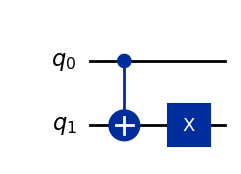

In [4]:
deutsch_func(3).draw("mpl")

In [9]:
def comp_circ(function: QuantumCircuit):
    # Compiles circuit for use in Deutsch's Algorithm
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)

    qc.x(n)
    qc.h(range(n+1))
    qc.barrier()

    qc.compose(function, inplace=True)
    qc.barrier()

    qc.h(range(n))
    qc.measure(range(n), range(n))

    return qc

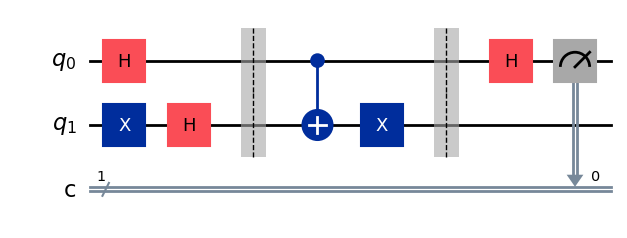

In [10]:
comp_circ(deutsch_func(3)).draw("mpl")

In [13]:
def deu_alg(function: QuantumCircuit):
    # Determine whether the func is constant or balanced
    qc = comp_circ(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()

    if measurements[0] == "0":
        return "constant"
    return "balanced"

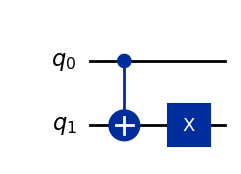

'balanced'

In [20]:
f = deutsch_func(3)
display(f.draw("mpl"))
display(deu_alg(f))

## Deutsch-Jozsa's Algorithm

In [27]:
def dj_func(num_qubits):
    # Create a random DJ function
    qc = QuantumCircuit(num_qubits + 1)

    # Flip or return qubit with 50/50 chance
    if np.random.randint(0, 2):
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        return qc

    on_states = np.random.choice(
        range(2**num_qubits), # Numbers to sample from
        2**num_qubits // 2, # Number of samples
        replace=False, # Don't resample the states
    )

    def add_cx(qc, bit_string):
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        qc.barrier()
        qc = add_cx(qc, f"{state:0b}")
        qc.mcx(list(range(num_qubits)), num_qubits)
        qc = add_cx(qc, f"{state:0b}")

    qc.barrier()
    return qc

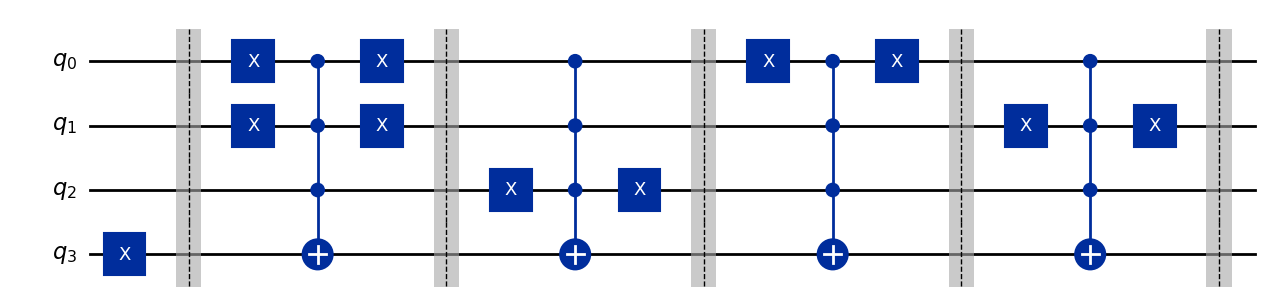

In [28]:
dj_func(3).draw("mpl")

In [36]:
def compile_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in the Deutsch_Jozsa algorithm
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    return qc

In [37]:
def dj_alg(function: QuantumCircuit):
    # Determine if function is constant or balanced
    qc = compile_circuit(function)

    result = AerSimulator().run(qc, shots=1, memory=True).result()
    measurements = result.get_memory()

    if "1" in measurements[0]:
        return "balanced"
    return "constant"

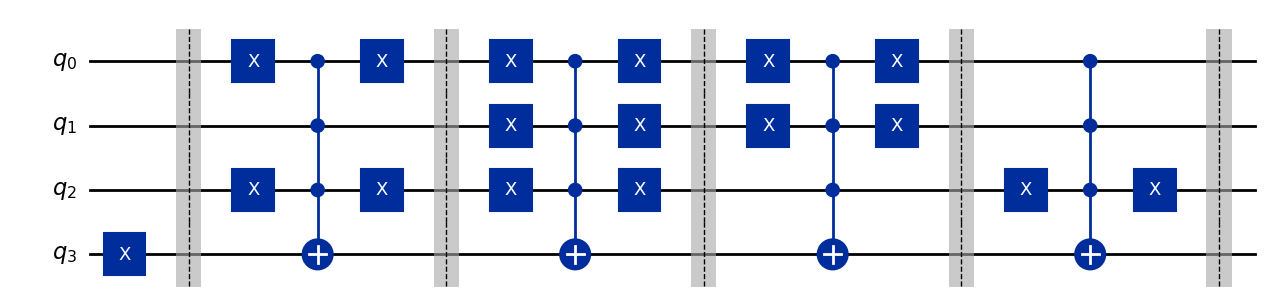

'balanced'

In [66]:
f = dj_func(3)
display(f.draw("mpl"))
display(dj_alg(f))

## The Bernstein-Vazirani Problem

In [70]:
def bv_func(s):
    # Create a BV func from a string of 0s and 1s
    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, len(s))
    return qc

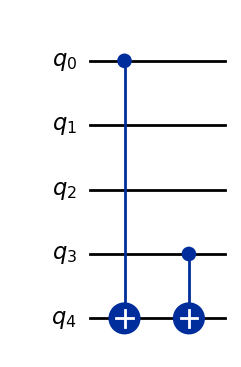

In [71]:
bv_func("1001").draw("mpl")

In [72]:
def bv_alg(function: QuantumCircuit):
    qc = compile_circuit(function)
    result = AerSimulator().run(qc, shots=1, memory=True).result()
    return result.get_memory()[0]

In [73]:
bv_alg(bv_func("1001"))

'1001'

## Simon's Algorithm

In [75]:
def simon_func(s: str):
    # Create a quantum circuit to implement a query gate for simon's problem obeying the promise for s

    # Our quantum circuit has 2n qubits for len(s)
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Define a random permutation of all n bit strings
    pi = np.random.permutation(2 ** n)

    # Next we want to define a function g which is a minimised funciton either all-zero or some non-all-zero value, which we will
    # compose with the random permutation pi which will satisfy the promise of s
    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1
    qc.unitary(query_gate, range(2 * n))
    return qc

In [77]:
def simon_meas(problem: QuantumCircuit, k: int):
    # Given a QC that implements f, you get k measurements to be post-processed
    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    result = AerSimulator().run(qc, shots=k, memory=True).result()
    return result.get_memory()

In [78]:
simon_meas(simon_func("11011"), k = 12)

['01110',
 '11100',
 '01101',
 '10110',
 '10101',
 '01110',
 '11111',
 '10010',
 '01110',
 '11100',
 '01001',
 '01110']

In [82]:
def simon_alg(problem: QuantumCircuit):
    # Return the hidden string s
    measurements = simon_meas(problem, k = problem.num_qubits // 2 + 10)
    print("Measurement results: ")
    display(measurements)

    # Classical Post-Processing
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    null_space = galois.GF(2)(matrix).null_space()
    print("Null Space:")
    display(null_space)

    print("Guess for hidden string s:")
    if len(null_space) == 0:
        # No non-trivial solution, returns all-zero value string
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))

In [93]:
simon_alg(simon_func("10011"))

Measurement results: 


['11110',
 '10101',
 '10001',
 '10010',
 '00111',
 '10010',
 '11010',
 '00111',
 '10101',
 '10101',
 '00011',
 '10010',
 '01000',
 '11110',
 '01111']

Null Space:


GF([[1, 0, 0, 1, 1]], order=2)

Guess for hidden string s:


'10011'